In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx


# Helper function to find files

In [6]:
def abs_path(target_name, directory_level): 
    """
Returns absolute file path of target name in working directory.

Arguments:
    target_name (str): Name of file or folder to find.
    directory_level (str): Level of os search, either File or Folder.   
    """
    #Find the relative working directory of the script
    wk_dir = os.path.dirname(os.path.realpath('__file__'))
    
    if directory_level == "File":
        #Absolute file path
        for root, dirs, files in os.walk(wk_dir):
            for name in files:
                if target_name == name:
                    target_path = (os.path.abspath(os.path.join(root, name))) 
             
    #Absolute file path
    if directory_level == "Directory":
        for root, dirs, files in os.walk(wk_dir):
            for name in dirs:
                if target_name == name:
                    target_path = (os.path.abspath(os.path.join(root, name))) 
    
    return target_path

# Mutation burden of simulated sequences

In [7]:
def mut_burden(cancer_type, simulation_type, gen_start, gen_end):

    mutation_burden = pd.DataFrame(index = range(gen_start, gen_end+1), columns = ['sbs', 'dbs', 'ins', 'del'])

    for gen in range(gen_start, gen_end+1):
        try:
            sbs_burden = pd.read_csv(abs_path(cancer_type + '_' + str(simulation_type) + '_Stage_Lineage_' + str(gen) + '_' + "sbs" + '_freq_table.csv', 'File'))['Frequency'].sum()
            dbs_burden = pd.read_csv(abs_path(cancer_type + '_' + str(simulation_type) + '_Stage_Lineage_' + str(gen) + '_' + "dbs" + '_freq_table.csv', 'File'))['Frequency'].sum()
            ins_burden = pd.read_csv(abs_path(cancer_type + '_' + str(simulation_type) + '_Stage_Lineage_' + str(gen) + '_' + "ins" + '_freq_table.csv', 'File'))['Frequency'].sum()
            del_burden = pd.read_csv(abs_path(cancer_type + '_' + str(simulation_type) + '_Stage_Lineage_' + str(gen) + '_' + "del" + '_freq_table.csv', 'File'))['Frequency'].sum()

            mutation_burden.iloc[list(range(gen_start, gen_end+1)).index(gen), 0] = sbs_burden
            mutation_burden.iloc[list(range(gen_start, gen_end+1)).index(gen), 1] = dbs_burden
            mutation_burden.iloc[list(range(gen_start, gen_end+1)).index(gen), 2] = ins_burden
            mutation_burden.iloc[list(range(gen_start, gen_end+1)).index(gen), 3] = del_burden
        except:
            print(gen)
        

    return mutation_burden

In [8]:
foo = mut_burden("Liver-HCC", "End", 0,499)


In [9]:
foo.head(10)

,sbs,dbs,ins,del
0,226,0,1,5
1,209,2,1,2
2,178,4,2,3
3,198,1,2,6
4,211,1,2,3
5,200,3,2,3
6,201,1,1,5
7,199,1,1,7
8,221,2,3,3
9,205,0,1,3


# Reference data

In [10]:
"""
Input sequence file path
"""
input_file_path = abs_path("Homo_sapiens.GRCh38.dna.chromosome.22.fasta", "File")
# print(input_sequence)
#input_sequence = seq_slice(input_file_path, 26100000, 27100000)
sig_weights =  pd.read_csv(abs_path("timelines_sigWeights.txt", "File"), sep='\t')
"""
Read in input reference files:
data = Pandas Dataframe of number of mutations attributed to each signature for each sample.
cancer_type = List of unique cancer types.
prop_data = Pandas Dataframe of proportion of 96 type mutation classification for each signature.
"""

"""
SBS input reference files
"""
sbs_num_file_path = abs_path("PCAWG_sigProfiler_SBS_signatures_in_samples.csv","File")
sbs_num_data = pd.read_csv(sbs_num_file_path)
sbs_num_data.sort_values(by='Cancer Types', axis=0, inplace=True)
sbs_num_data.set_index(keys=['Cancer Types'], drop=False,inplace=True)

sbs_prop_file_path = abs_path("sigProfiler_SBS_signatures.csv","File")
sbs_prop_data = pd.read_csv(sbs_prop_file_path)
  

"""
DBS input reference files
"""
dbs_num_file_path = abs_path("PCAWG_sigProfiler_DBS_signatures_in_samples.csv","File")
dbs_num_data = pd.read_csv(dbs_num_file_path)
dbs_num_data.sort_values(by='Cancer Types', axis=0, inplace=True)
dbs_num_data.set_index(keys=['Cancer Types'], drop=False,inplace=True)

dbs_prop_file_path = abs_path("sigProfiler_DBS_signatures.csv","File")
dbs_prop_data = pd.read_csv(dbs_prop_file_path)


"""
Insertion/Deletion input reference files
"""
id_num_file_path = abs_path("PCAWG_SigProfiler_ID_signatures_in_samples.csv","File")
id_num_data = pd.read_csv(id_num_file_path)
id_num_data.sort_values(by='Cancer Types', axis=0, inplace=True)
id_num_data.set_index(keys=['Cancer Types'], drop=False,inplace=True)

id_prop_file_path = abs_path("sigProfiler_ID_signatures.csv","File")
id_prop_data = pd.read_csv(id_prop_file_path)


"""
Expected Frequency Absolute Folder Paths for SBS, DBS and ID
"""
sbs_freq_folder_path = abs_path("SBS_Expected_Frequency", "Directory")
dbs_freq_folder_path = abs_path("DBS_Expected_Frequency", "Directory")
id_freq_folder_path = abs_path("ID_Expected_Frequency", "Directory")

#%%


def sig_proportion(cancer_type, num_data, std_outlier):
    """
Find the proportions of different combinations of signatures among all samples
Output proportion of samples with each combination of signatures. 

Arguments:
    cancer_type (str): Cancer type 
    num_data (dataframe): Signature data
    std_outlier (float): Parameter to exclude outliers by degrees of standard deviation 
    """
    #Setup dataframe with signature data
    n_mutation_df = num_data.loc[cancer_type,"Sample Names":]
    n_mutation_df.set_index("Sample Names", inplace=True)
    del n_mutation_df['Accuracy']
    
    cols = n_mutation_df.columns
    
    #Find contributing signature combinations for each sequence
    sig_combos = list(n_mutation_df.apply(lambda x: x > 0).apply(lambda x: list(n_mutation_df.columns[x.values]), axis=1))
  
    #Find the set of unique contributing signature combinations 
    unique_sig_combos = [list(x) for x in set(tuple(x) for x in sig_combos)]
    
    
    #All outliers found for each sequence in no particular order
    net_outlier_sample = []
    
    for index in unique_sig_combos:
        combo_df = n_mutation_df[index][(n_mutation_df[index] != 0).all(1)]
        filter_combo_df = combo_df[~(np.abs(combo_df-combo_df.mean()) > (std_outlier*combo_df.std()))]

        for sig in index:
            net_outlier_sample.append(filter_combo_df[filter_combo_df[sig].isnull()].index.tolist())
    
    #Set of unique outlier sequences
    set_outlier = list(set(x for l in net_outlier_sample for x in l))
    
    #print("Removed the following outliers from the signature combination probability matrix:" + str(set_outlier))

    #Drop outlier sequences 
    n_mutation_df.drop(set_outlier,inplace=True)
    
    #Dataframe of the proportion of a set of signatures contribution out of all possible combinations
    bt=n_mutation_df.apply(lambda x: x > 0)
    
    sig_prop = ( bt.apply( lambda x: (cols[x.values]) , axis=1).value_counts() ) / len(bt)
    
    return sig_prop



def outlier_detection(cancer_type, num_data, std_outlier):
    """
Identifies outliers in the dataframe, returns list of outliers

Arguments;
    cancer_type (str): Cancer type
    num_data (dataframe): Signature data
    std_outlier: Parameter to exclude outliers by degrees of standard deviation 
    """ 
    #Setup dataframe with signature data
    n_mutation_df = num_data.loc[cancer_type,"Sample Names":]
    n_mutation_df.set_index("Sample Names", inplace=True)
    del n_mutation_df['Accuracy']
    
    #Find contributing signature combinations for each sequence
    sig_combos = list(n_mutation_df.apply(lambda x: x > 0).apply(lambda x: list(n_mutation_df.columns[x.values]), axis=1))
  
    #Find the set of unique contributing signature combinations 
    unique_sig_combos = [list(x) for x in set(tuple(x) for x in sig_combos)]
    
    #All outliers found for each sequence in no particular order
    net_outlier_sample = []
    
    for index in unique_sig_combos:
        combo_df = n_mutation_df[index][(n_mutation_df[index] != 0).all(1)]
        filter_combo_df = combo_df[~(np.abs(combo_df-combo_df.mean()) > (std_outlier*combo_df.std()))]

        for sig in index:
            net_outlier_sample.append(filter_combo_df[filter_combo_df[sig].isnull()].index.tolist())
    
    #Set of unique outlier sequences
    set_outlier = list(set(x for l in net_outlier_sample for x in l))
    
    return set_outlier

In [11]:
def ref_data(input_name, num=False, prop=False):
    """
Reads in reference datasets from PCAWG studies.

Arguments:
    input_name (str): Name of csv file 
    num (bool): Set true to return dataframe of PCAWG SigProfiler Signatures in Samples 
    prop (bool): Set true to return dataframe of SigProfiler Signature Contributions
    
Note: Must set only one of num or prop arguments to True. 
    """
    if prop == num:
        raise ValueError("Please set only one argument between the arguments num and prop to True.")
        
    if num is True:
        
        num_file_path = abs_path(input_name, "File")
        num_data = pd.read_csv(num_file_path)
        num_data.sort_values(by='Cancer Types', axis=0, inplace=True)
        num_data.set_index(keys=['Cancer Types'], drop=False,inplace=True)
        
        return num_data

    if prop is True:
            
        prop_file_path = abs_path(input_name, input_type )
        prop_data = pd.read_csv(prop_file_path)
        
        return prop_data
    

In [12]:
def mut_mean(cancer_type, num_data, freq_folder_path, mut_type, std_outlier):
    """
Output average number of 96 type mutations among all samples for specified cancer type.

Arguments:
    cancer_type (str): Cancer type
    num_data (dataframe): Signature data
    freq_folder_path (str): Folder with expected mutation frequencies for each sample
    mut_type (str): "SBS", "DBS", "ID"
    std_outlier (float): Parameter to exclude outliers by degrees of standard deviation 
    """
    if mut_type == "SBS":
         
        outlier_list = outlier_detection(cancer_type, num_data, std_outlier)
        outlier_paths = [abs_path("SBS_" + cancer_type + "_" + outlier + ".csv", "File") for outlier in outlier_list]
        file_paths = glob.glob(str(sbs_freq_folder_path) + "/SBS_" + cancer_type + '_*' + '.csv')
        filtered_file_paths = [x for x in file_paths if x not in outlier_paths]
        

        #print("Removed " + str(len(file_paths)-len(filtered_file_paths)) + " outliers from the average mutation frequency matrix")
        #print(outlier_list)
        
        og_df = pd.read_csv(filtered_file_paths[0])
        mean_df = og_df.loc[:, 'SBS1':]
    
        for file_index in range(1, len(file_paths)):
            raw_mean = pd.read_csv(file_paths[file_index])
            slice_read_df = raw_mean.loc[:, 'SBS1':]
            mean_df += slice_read_df
            
        df_averages = mean_df/len(file_paths) 
        mut_subtypes = og_df.loc[:, 'Type': 'SubType']
        average_freq_df = pd.concat([mut_subtypes, df_averages], axis=1)
        
        return average_freq_df
  
    if mut_type == "DBS":
        
        outlier_list = outlier_detection(cancer_type, num_data, std_outlier)
        outlier_paths = [abs_path("DBS_" + cancer_type + "_" + outlier + ".csv", "File") for outlier in outlier_list]
        file_paths = glob.glob(str(dbs_freq_folder_path)+ "/DBS_" + cancer_type + '_*' + '.csv')
        filtered_file_paths = [x for x in file_paths if x not in outlier_paths]
        
        #print("Dropped " + str(len(file_paths)-len(filtered_file_paths)) + " outliers!")
        #print("")
        #print(outlier_list)
        
        og_df = pd.read_csv(filtered_file_paths[0], index_col=0)
        mean_df = og_df.loc[:, 'DBS1':]
        
        for file_index in range(1, len(file_paths)):
            raw_mean = pd.read_csv(file_paths[file_index])
            slice_read_df = raw_mean.loc[:, 'DBS1':]
            mean_df += slice_read_df
            
        dbs_df_averages = mean_df/len(file_paths) 
        mut_subtypes = og_df.loc[:,'Mutation Type'].to_frame() 
        average_freq_df = pd.concat([mut_subtypes, dbs_df_averages], axis=1)
        
        return average_freq_df

    if mut_type == "ID":
        
        outlier_list = outlier_detection(cancer_type, num_data, std_outlier)
        outlier_paths = [abs_path("ID_" + cancer_type + "_" + outlier + ".csv", "File") for outlier in outlier_list]
        file_paths = glob.glob(str(id_freq_folder_path) + "/ID_" + cancer_type + '_*' + '.csv')
        filtered_file_paths = [x for x in file_paths if x not in outlier_paths]
        
        #print("Dropped " + str(len(file_paths)-len(filtered_file_paths)) + " outliers!")
        #print("")
        #print(outlier_list)
        
        og_df = pd.read_csv(filtered_file_paths[0], index_col=0)
        mean_df = og_df.loc[:, 'ID1':]
        
        for file_index in range(1, len(file_paths)):
            raw_mean = pd.read_csv(file_paths[file_index])
            slice_read_df = raw_mean.loc[:, 'ID1':]
            mean_df += slice_read_df
            
        id_df_averages = mean_df/len(file_paths) 
        mut_subtypes = og_df.loc[:,'Mutation Type':'ID_type']
        average_freq_df = pd.concat([mut_subtypes, id_df_averages], axis=1)
        
        return average_freq_df
  
    if mut_type not in ["SBS", "DBS", "ID"]:
        raise ValueError("It looks like you did not input an appropriate mut_type argument (SBS, DBS, ID)")

    else: 
        print("Completed calculations of average " + str(mut_type) + "mutation expected frequency for " + str(cancer_type))

 

In [13]:
def mut_prob(cancer_type, prop_data, num_data, freq_folder_path, mut_type, std_outlier):
    """
Output dictionary of probability of mutation for any given k-mer in whole genome sequence

Arguments:
    cancer_type (str): Cancer type
    prop_data (dataframe): Signature proportion data
    num_data (dataframe): Signature frequency data
    freq_folder_path (str): Folder with expected mutation frequencies for each sample
    mut_type (str): "SBS", "DBS", "ID"
    std_outlier (float): Parameter to exclude outliers by degrees of standard deviation 
    """
    if mut_type == "SBS":
        
        sbs_mut = mut_mean(cancer_type, num_data, freq_folder_path, mut_type, std_outlier)
        sbs_mut['total'] = sbs_mut['SubType'].map(kmer_3_count.set_index('kmer')['count'])
        sbs_mut_prob = sbs_mut.loc[:,'SBS1':'SBS60'].div(sbs_mut.total, axis=0)
        sbs_index_mut_prob = pd.concat([sbs_mut[['Type', 'SubType']], sbs_mut_prob], axis=1)
        sbs_index_mut_prob.sort_values(['SubType','Type']).set_index(['SubType','Type'],inplace=True)
    
        return sbs_index_mut_prob
    
    if mut_type == "DBS":

        dbs_mut = mut_mean(cancer_type, num_data, freq_folder_path, mut_type, std_outlier)
        dbs_mut['2mer_index'] = dbs_mut['Mutation Type'].apply(lambda x: x[:2])
        dbs_mut['total'] = dbs_mut['2mer_index'].map(kmer_2_count.set_index('kmer')['count'])
        dbs_mut_prob = dbs_mut.loc[:,'DBS1':'DBS11'].div(dbs_mut['total'], axis=0)
        dbs_index_mut_prob = pd.concat([dbs_mut[['Mutation Type', '2mer_index']], dbs_mut_prob], axis=1)
        dbs_index_mut_prob.sort_values(['Mutation Type']).set_index(['Mutation Type'],inplace=True)
   
        return dbs_index_mut_prob
    
    if mut_type == "ID":

        id_mut = mut_mean(cancer_type, num_data, freq_folder_path, mut_type, std_outlier)
        id_mut['Index'] = id_prop_data['Index']
        
        id_kmer_count_1_6 = kmer_1_count.append([kmer_2_count,
                                                 kmer_3_count,
                                                 kmer_4_count,
                                                 kmer_5_count,
                                                 kmer_6_count])
        
        id_mut['total'] = id_mut['Index'].map(id_kmer_count_1_6.set_index('kmer')['count'])
        
        id_mut_prob = id_mut.loc[:,'ID1':'ID17'].div(id_mut['total'], axis=0)
        id_index_mut_prob_1_6 = pd.concat([id_mut.loc[:, 'Mutation Type':'ID_type'], id_mut_prob], axis=1)
        id_index_mut_prob_1_6.sort_values(['Mutation Type']).set_index(['Mutation Type'],inplace=True)
      
        return id_index_mut_prob_1_6
    
    if mut_type not in ["SBS", "DBS", "ID"]:
        raise ValueError("It looks like you did not input an appropriate mut_type argument (SBS, DBS, ID)")
   
    else:
        print("Completed calculations of " + str(mut_type) + "mutation probabilities for " + str(cancer_type))

In [14]:
def genome_kmer_count(kmer_length, kmer_count_folder_path = abs_path("kmer_ref_count", "Directory")):
    """
Output genome kmer counts (Chr1-22, X and Y) of reference genome GChr38

Arguments:
    kmer_length: Counts of k-mers in reference sequence at specified length
    kmer_count_folder_path: Folder path of kmer counts, default is folder of reference genome kmer counts 
    """
    chr_index = [i for i in range(kmer_length + 1 ,23)]
    chr_index.append('X')
    chr_index.append('Y')
    
    chr_1 = pd.read_csv(kmer_count_folder_path + '/' + str(kmer_length) + '-mer/' + str(kmer_length) + '-mer_chr1.csv')
    total_kmer_count = pd.read_csv(kmer_count_folder_path + '/' + str(kmer_length) + '-mer/' + str(kmer_length) + '-mer_chr1.csv').loc[:, 'count']
    
    for file_name in chr_index:
        read_in = pd.read_csv(kmer_count_folder_path + '/' + str(kmer_length) + '-mer/' + str(kmer_length) + '-mer_chr' + str(file_name) + '.csv').loc[:, 'count']
        total_kmer_count += read_in
 
    return pd.concat([chr_1.iloc[:,1], total_kmer_count], axis=1)

kmer_count_folder_path = abs_path("kmer_ref_count", "Directory")
#/Users/DavidChen/Desktop/Project/kmer_ref_count

kmer_1_count = genome_kmer_count(1, kmer_count_folder_path)
kmer_1_count.columns = ['kmer', 'count']
kmer_2_count = genome_kmer_count(2, kmer_count_folder_path)
kmer_2_count.columns = ['kmer', 'count']
kmer_3_count = genome_kmer_count(3, kmer_count_folder_path)
kmer_3_count.columns = ['kmer', 'count']
kmer_4_count = genome_kmer_count(4, kmer_count_folder_path)
kmer_4_count.columns = ['kmer', 'count']
kmer_5_count = genome_kmer_count(5, kmer_count_folder_path)
kmer_5_count.columns = ['kmer', 'count']
kmer_6_count = genome_kmer_count(6, kmer_count_folder_path)
kmer_6_count.columns = ['kmer', 'count']

# Reference Genome Length

In [15]:
kmer_ref = (glob.glob("/Users/davidchen/Documents/GitHub/SomaticSiMu/kmer_ref_count/6-mer/6-mer_chr*"))
kmer_count = pd.read_csv(kmer_ref[0], index_col=0)['count'].fillna(0)
for i in kmer_ref[1:-1]:
    sample = pd.read_csv(i, index_col=0)['count'].fillna(0)
    kmer_count = kmer_count + sample

kmer_reference_count_dict = dict(zip(pd.read_csv(kmer_ref[0], index_col=0)["6"], kmer_count))
ref_genome_length = sum(kmer_reference_count_dict.values())

# Normalize genome mutation burden to input seq

In [16]:
def normalize_ref_burden(cancer_type, num_data, std_outlier, input_seq_length):
    #outliers = outlier_detection(cancer_type, num_data, std_outlier)
    bar = num_data[num_data['Cancer Types'] == cancer_type]
    #bar = bar[~bar['Sample Names'].isin(outliers)]
    ref_mut_burden = list(bar.iloc[:, 3:].sum(axis=1))
    ref_mut_burden = [i * (input_seq_length/ref_genome_length) for i in ref_mut_burden]
    return ref_mut_burden

In [17]:
ref_mut_burden = normalize_ref_burden(cancer_type="Liver-HCC", num_data=sbs_num_data, std_outlier=3, input_seq_length = 50818467)

In [18]:
ref_mut_burden

[285.4872567904862,
 220.3733966099499,
 385.6664184019329,
 279.553661136415,
 161.85049836586006,
 75.42413134621097,
 299.6206318615537,
 157.30083172731568,
 154.44647813279164,
 166.93643749792108,
 120.28073056197361,
 216.51569447916893,
 132.96098016673798,
 371.34275309123046,
 290.62509326062946,
 196.63901399366517,
 177.76568204441836,
 229.62842190128544,
 213.02127371496374,
 275.7997536817985,
 330.6033426966601,
 351.4833717184208,
 141.59323740108644,
 184.37394309355886,
 149.74111948000052,
 185.3599925171217,
 246.87563725728828,
 160.17248443453383,
 309.51572432257035,
 151.22884317169184,
 200.42751967366982,
 325.7422920296222,
 42.763406579778334,
 174.09827015327232,
 310.3806799572746,
 306.38458492494095,
 198.87059953120215,
 108.41353925383123,
 123.70595487540245,
 182.93811673994978,
 113.17079524470464,
 257.96436849419683,
 380.5804792698719,
 282.20042537861,
 488.26745579055154,
 276.33602617531517,
 253.98557257455724,
 106.26844927976468,
 308.1317

In [19]:
simulated_mut_burden = mut_burden("Liver-HCC", "End", 0,499)['sbs'].tolist()

In [20]:
means = [np.mean(ref_mut_burden) , np.mean(simulated_mut_burden)]

In [21]:
yerr = [np.std(ref_mut_burden) , np.std(simulated_mut_burden)]

# Plot mean mutation burden 

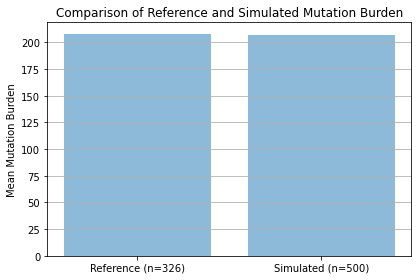

In [22]:
fig, ax = plt.subplots()
ax.bar(np.arange(2), means, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Mean Mutation Burden')
ax.set_xticks(np.arange(2))
ax.set_xticklabels(["Reference " + "(n=" + str(len(ref_mut_burden)) +")", "Simulated " + "(n=" + str(len(simulated_mut_burden)) +")"]) 
ax.set_title('Comparison of Reference and Simulated Mutation Burden')

ax.yaxis.grid(True)



# Save the figure and show
plt.tight_layout()
plt.show()

# Unequal variances T-test


Welch's t-test, or unequal variances t-test, is a two-sample location test which is used to test the hypothesis that two populations have equal means.  More reliable when the two samples have unequal variances and/or unequal sample sizes. 

Accept the null hypothesis that there is no difference between means.

In [23]:
#General rule: If variance ratio between two populations is less than 4:1, conduct two sample T-test, 
#else conduct Welch's T Test

(np.var(ref_mut_burden), np.var(simulated_mut_burden))

(12475.389821724011, 713.9179)

In [24]:
stats.ttest_ind(simulated_mut_burden, ref_mut_burden, equal_var=False)

Ttest_indResult(statistic=-0.16112988866556763, pvalue=0.8720842356625986)

# Magnitude Spectra Significance

In [25]:
kmer_ref = (glob.glob("/Users/davidchen/Documents/GitHub/SomaticSiMu/kmer_ref_count/3-mer/3-mer_chr*"))
kmer_count = pd.read_csv(kmer_ref[0], index_col=0)['count'].fillna(0)
for i in kmer_ref[1:-1]:
    sample = pd.read_csv(i, index_col=0)['count'].fillna(0)
    kmer_count = kmer_count + sample

kmer_reference_count_dict = dict(zip(pd.read_csv(kmer_ref[0], index_col=0)["3"], kmer_count))
ref_genome_length = sum(kmer_reference_count_dict.values())

In [26]:
kmer_reference_count_dict

{'CTA': 37835932,
 'TAA': 45597483,
 'AAC': 47201257,
 'ACC': 44545092,
 'CCC': 48300023,
 'CCT': 45730577,
 'CTC': 47302637,
 'TCT': 50948756,
 'CTG': 52003277,
 'TGA': 43214327,
 'GAA': 46533925,
 'AAA': 60869629,
 'AAG': 48984923,
 'AGT': 44588381,
 'GTG': 43579729,
 'TGG': 50679722,
 'GGA': 43968250,
 'GAC': 49542535,
 'TAT': 52679409,
 'ATC': 45164540,
 'TCA': 41218974,
 'CAG': 40991591,
 'AGC': 47212118,
 'GCA': 42425256,
 'AGG': 44019928,
 'GAT': 45151568,
 'ATG': 55474454,
 'TGT': 47088446,
 'GGG': 40578029,
 'GGT': 53518593,
 'GAG': 48853223,
 'AGA': 44175222,
 'ATT': 50532168,
 'TTA': 43695544,
 'TAG': 44808019,
 'AAT': 54457890,
 'ATA': 43606596,
 'ACT': 42819269,
 'TGC': 41195213,
 'GCC': 42141983,
 'CCA': 45063698,
 'GGC': 48080493,
 'CAA': 39584962,
 'GTC': 43506794,
 'TCC': 37295203,
 'CTT': 44115524,
 'TTT': 44717254,
 'TTC': 44741472,
 'CAT': 38376928,
 'TAC': 37357458,
 'GCT': 42321815,
 'TCG': 32072699,
 'CGT': 24851341,
 'GTT': 32507855,
 'CAC': 38839731,
 'TTG': 36

In [27]:
def normalize_ref_spectra(cancer_type, num_data, std_outlier, input_seq_length):
    #outliers = outlier_detection(cancer_type, num_data, std_outlier)
    bar = num_data[num_data['Cancer Types'] == cancer_type]
    #bar = bar[~bar['Sample Names'].isin(outliers)]
    ref_mut_burden = list(bar.iloc[:, 3:].sum(axis=1))
    ref_mut_burden = [i * (input_seq_length/ref_genome_length) for i in ref_mut_burden]
    return ref_mut_burden

In [28]:
def mut_type(cancer_type, simulation_type, gen_start, gen_end, mtype, seq_len):
    
    if mtype == "sbs":
        mutation_spectra = pd.DataFrame(index = range(96))
        mutation_spectra['Type'] = sbs_prop_data['Type']
        mutation_spectra['SubType'] = sbs_prop_data['SubType']

    for gen in range(gen_start, gen_end+1):
        try:
            sbs_spectra = pd.read_csv(abs_path(cancer_type + '_' + str(simulation_type) + '_Stage_Lineage_' + str(gen) + '_' + "sbs" + '_freq_table.csv', 'File'))['Frequency']        
            sbs_spectra = sbs_spectra.div(seq_len)
            mutation_spectra[str(gen)] = sbs_spectra
           
        except:
            print(gen)
        
    return mutation_spectra

In [29]:
sim_mut_spectra = mut_type("Liver-HCC", simulation_type="End", gen_start=0, gen_end=499, mtype="sbs", seq_len=50818467)

In [30]:
sim_mut_spectra

,Type,SubType,0,1,2,3,4,5,6,7,...,490,491,492,493,494,495,496,497,498,499
0,C>A,ACA,5.903366e-08,5.903366e-08,7.871154e-08,9.838943e-08,5.903366e-08,1.967789e-08,3.935577e-08,7.871154e-08,...,3.935577e-08,5.903366e-08,3.935577e-08,3.935577e-08,5.903366e-08,7.871154e-08,7.871154e-08,7.871154e-08,1.967789e-08,9.838943e-08
1,C>A,ACC,1.967789e-07,1.574231e-07,3.935577e-08,2.361346e-07,1.574231e-07,2.164567e-07,2.361346e-07,1.574231e-07,...,7.871154e-08,1.180673e-07,1.180673e-07,1.180673e-07,9.838943e-08,1.180673e-07,1.377452e-07,7.871154e-08,2.361346e-07,2.164567e-07
2,C>A,ACG,7.871154e-08,9.838943e-08,1.967789e-08,3.935577e-08,1.967789e-08,7.871154e-08,1.967789e-08,7.871154e-08,...,7.871154e-08,1.967789e-08,1.967789e-08,1.967789e-08,0.000000e+00,7.871154e-08,5.903366e-08,5.903366e-08,0.000000e+00,1.967789e-08
3,C>A,ACT,1.967789e-08,5.903366e-08,0.000000e+00,1.967789e-08,3.935577e-08,5.903366e-08,3.935577e-08,3.935577e-08,...,1.967789e-08,3.935577e-08,9.838943e-08,1.967789e-08,3.935577e-08,3.935577e-08,1.967789e-08,3.935577e-08,3.935577e-08,0.000000e+00
4,C>A,CCA,3.935577e-08,7.871154e-08,1.967789e-08,3.935577e-08,7.871154e-08,7.871154e-08,5.903366e-08,7.871154e-08,...,3.935577e-08,3.935577e-08,0.000000e+00,3.935577e-08,5.903366e-08,0.000000e+00,5.903366e-08,5.903366e-08,3.935577e-08,5.903366e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,T>G,GTT,3.935577e-08,1.967789e-08,1.967789e-08,1.967789e-08,3.935577e-08,3.935577e-08,1.967789e-08,3.935577e-08,...,1.967789e-08,1.967789e-08,1.180673e-07,0.000000e+00,3.935577e-08,5.903366e-08,1.967789e-08,1.967789e-08,1.967789e-08,3.935577e-08
92,T>G,TTA,3.935577e-08,1.967789e-08,1.967789e-08,1.967789e-08,5.903366e-08,3.935577e-08,3.935577e-08,3.935577e-08,...,3.935577e-08,0.000000e+00,0.000000e+00,3.935577e-08,1.967789e-08,1.967789e-08,5.903366e-08,3.935577e-08,5.903366e-08,0.000000e+00
93,T>G,TTC,3.935577e-08,1.180673e-07,3.935577e-08,1.967789e-08,7.871154e-08,0.000000e+00,5.903366e-08,3.935577e-08,...,1.967789e-08,5.903366e-08,5.903366e-08,3.935577e-08,7.871154e-08,1.967789e-08,3.935577e-08,3.935577e-08,3.935577e-08,3.935577e-08
94,T>G,TTG,1.180673e-07,1.967789e-08,1.377452e-07,5.903366e-08,1.377452e-07,5.903366e-08,1.967789e-08,3.935577e-08,...,2.558125e-07,0.000000e+00,9.838943e-08,1.967789e-07,7.871154e-08,5.903366e-08,1.574231e-07,7.871154e-08,9.838943e-08,5.903366e-08


In [31]:
ref_mut_spectra = mut_prob(cancer_type="Liver-HCC", prop_data=sbs_prop_data, num_data=sbs_num_data, freq_folder_path=sbs_freq_folder_path, mut_type="SBS", std_outlier=3).iloc[:, 2:]

In [32]:
ref_mut_spectra

,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,SBS7d,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,2.151708e-09,0.0,0.0,9.218182e-07,2.610684e-06,6.422036e-10,0.0,0.0,0.0,0.0,...,0.0,0.0,1.104609e-10,1.945248e-10,0.0,8.082993e-10,0.0,0.0,0.0,0.0
1,4.691692e-09,0.0,0.0,6.163426e-07,1.740164e-06,6.709038e-10,0.0,0.0,0.0,0.0,...,0.0,0.0,3.409789e-11,6.074065e-11,0.0,8.533879e-10,0.0,0.0,0.0,0.0
2,4.629759e-10,0.0,0.0,3.670228e-07,4.334913e-07,8.462968e-11,0.0,0.0,0.0,0.0,...,0.0,0.0,8.425327e-10,1.590745e-10,0.0,1.423326e-11,0.0,0.0,0.0,0.0
3,2.764616e-09,0.0,0.0,5.730997e-07,1.278939e-06,2.418977e-10,0.0,0.0,0.0,0.0,...,0.0,0.0,3.122466e-13,3.315866e-11,0.0,1.312215e-09,0.0,0.0,0.0,0.0
4,5.916712e-10,0.0,0.0,1.376520e-06,1.262229e-06,2.147492e-09,0.0,0.0,0.0,0.0,...,0.0,0.0,5.354871e-09,4.444415e-12,0.0,1.242309e-10,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,3.543170e-11,0.0,0.0,5.500764e-09,5.108937e-07,1.188360e-09,0.0,0.0,0.0,0.0,...,0.0,0.0,4.164970e-11,1.088921e-12,0.0,7.307960e-12,0.0,0.0,0.0,0.0
92,8.054566e-22,0.0,0.0,1.224791e-08,1.689007e-06,2.359722e-10,0.0,0.0,0.0,0.0,...,0.0,0.0,3.969697e-11,4.339643e-12,0.0,9.025694e-10,0.0,0.0,0.0,0.0
93,1.069796e-10,0.0,0.0,3.038658e-09,1.140977e-06,3.467093e-10,0.0,0.0,0.0,0.0,...,0.0,0.0,7.156695e-11,5.083066e-11,0.0,5.128632e-14,0.0,0.0,0.0,0.0
94,2.098312e-09,0.0,0.0,7.510570e-08,2.237611e-06,7.255726e-10,0.0,0.0,0.0,0.0,...,0.0,0.0,1.871343e-10,1.026360e-09,0.0,9.602297e-12,0.0,0.0,0.0,0.0


In [33]:
cosine_sim_96 = pd.DataFrame(index=range(500), columns=list(ref_mut_spectra.columns))

In [34]:
for i in range(500):
    for j in cosine_sim_96.columns:
        cosine_sim_96.loc[i,j] = np.min(cosine_similarity([list(ref_mut_spectra.loc[:, j]), list(sim_mut_spectra.iloc[:, 2:].iloc[:,i])]))

In [35]:
cosine_sim_96

,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,SBS7d,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,0.154646,0,0,0.398867,0.344562,0.209645,0,0,0,0,...,0,0,0.155224,0.0959949,0,0.319126,0,0,0,0
1,0.149461,0,0,0.421696,0.441726,0.200521,0,0,0,0,...,0,0,0.276678,0.0982043,0,0.220893,0,0,0,0
2,0.150668,0,0,0.332233,0.393572,0.160502,0,0,0,0,...,0,0,0.167287,0.167297,0,0.271742,0,0,0,0
3,0.11029,0,0,0.401372,0.376466,0.173888,0,0,0,0,...,0,0,0.183148,0.0938755,0,0.222857,0,0,0,0
4,0.148212,0,0,0.361679,0.361501,0.160283,0,0,0,0,...,0,0,0.20985,0.0761678,0,0.241338,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.172229,0,0,0.417971,0.406931,0.160628,0,0,0,0,...,0,0,0.133686,0.111562,0,0.241128,0,0,0,0
496,0.0901394,0,0,0.370857,0.335468,0.134555,0,0,0,0,...,0,0,0.172732,0.0997457,0,0.244173,0,0,0,0
497,0.0199447,0,0,0.369318,0.374407,0.0755296,0,0,0,0,...,0,0,0.199857,0.102284,0,0.293393,0,0,0,0
498,0.0492838,0,0,0.370929,0.344599,0.094097,0,0,0,0,...,0,0,0.167919,0.141714,0,0.309748,0,0,0,0


In [36]:
cosine_sim_96.mean(axis=0)

SBS1     0.128631
SBS2     0.000000
SBS3     0.000000
SBS4     0.381194
SBS5     0.369154
           ...   
SBS56    0.251797
SBS57    0.000000
SBS58    0.000000
SBS59    0.000000
SBS60    0.000000
Length: 65, dtype: float64

In [37]:
cosine_sim_96.mean(axis=0).nlargest(5)

SBS40    0.503778
SBS4     0.381194
SBS5     0.369154
SBS29    0.332953
SBS9     0.325993
dtype: float64

In [38]:
network_df = pd.DataFrame(index=range(len(cosine_sim_96.columns)), columns = ["node1", "node2", "value"])

In [39]:
network_df['node1'] = "Liver-HCC"

In [40]:
network_df['node2'] = cosine_sim_96.columns

In [41]:
network_df['value'] = list(cosine_sim_96.mean(axis=0))

In [42]:
network_df[network_df['value']>0.3].sort_values('value')

,node1,node2,value
39,Liver-HCC,SBS35,0.302868
28,Liver-HCC,SBS24,0.320412
22,Liver-HCC,SBS18,0.325306
11,Liver-HCC,SBS9,0.325993
33,Liver-HCC,SBS29,0.332953
4,Liver-HCC,SBS5,0.369154
3,Liver-HCC,SBS4,0.381194
44,Liver-HCC,SBS40,0.503778


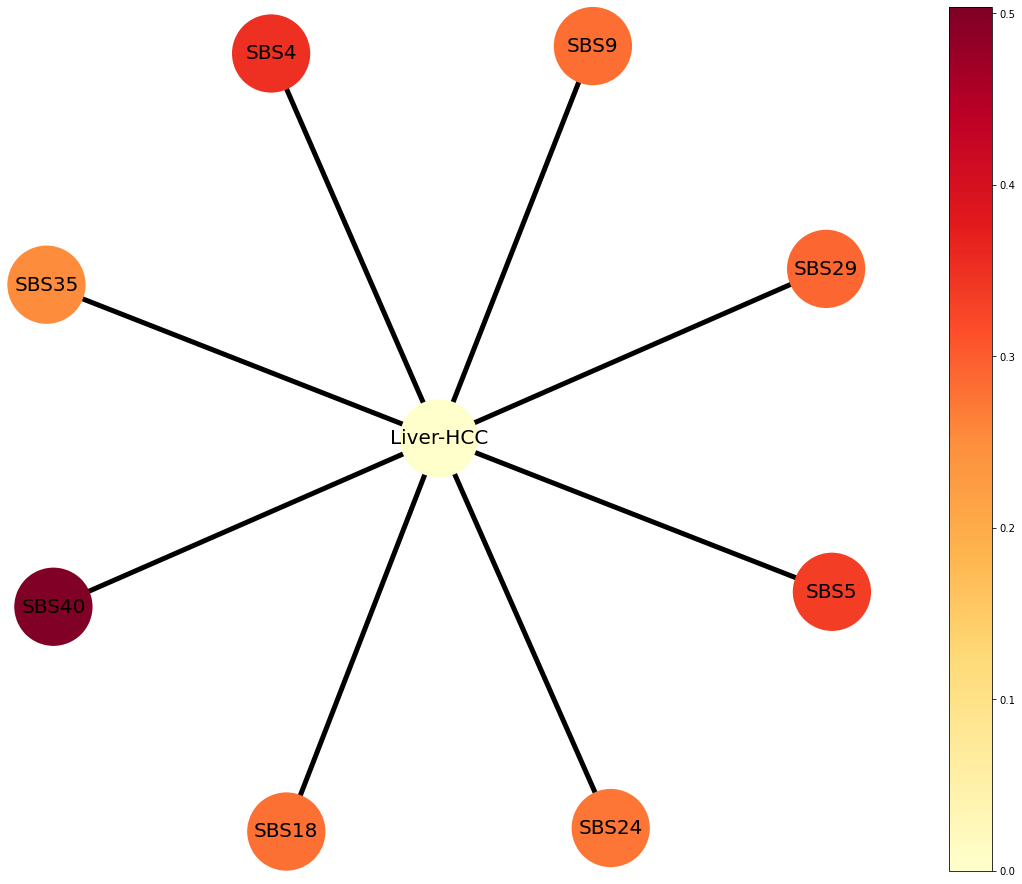

In [43]:
# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=network_df.loc[ (network_df['value'] > 0.3) & (network_df['node1'] != network_df['node2']) ]
links_filtered
 
plt.figure(2,figsize=(15,12)) 
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'node1', 'node2')

# Plot the network:
#colors = [i/len(G.nodes) for i in range(len(G.nodes))]
colors = network_df[network_df['value']>0.3]['value'].tolist()
colors.insert(0,0.1)
nx.draw_spring(G, with_labels=True, node_color=colors ,cmap=plt.cm.YlOrRd, node_size=800,linewidths=50, font_size=20, width=5)

vmin = network_df['value'].min()
vmax = network_df['value'].max()

sm = plt.cm.ScalarMappable(cmap="YlOrRd", norm=plt.Normalize(vmin=network_df['value'].min(), vmax=network_df['value'].max()))
sm.set_array([])
cbar = plt.colorbar(sm, anchor=(0.2,0.0))




In [44]:
sim_mut_spectra2 = mut_type("Biliary-AdenoCA", simulation_type="End", gen_start=0, gen_end=499, mtype="sbs", seq_len=50818467)
ref_mut_spectra2 = mut_prob(cancer_type="Biliary-AdenoCA", prop_data=sbs_prop_data, num_data=sbs_num_data, freq_folder_path=sbs_freq_folder_path, mut_type="SBS", std_outlier=3).iloc[:, 2:]



In [45]:
cosine_sim_962 = pd.DataFrame(index=range(500), columns=list(ref_mut_spectra2.columns))
for i in range(500):
    for j in cosine_sim_962.columns:
        cosine_sim_962.loc[i,j] = np.min(cosine_similarity([list(ref_mut_spectra2.loc[:, j]), list(sim_mut_spectra2.iloc[:, 2:].iloc[:,i])]))
        
network_df2 = pd.DataFrame(index=range(len(cosine_sim_962.columns)), columns = ["node1", "node2", "value"])

network_df2['node1'] = "Biliary-AdenoCA"
network_df2['node2'] = cosine_sim_962.columns
network_df2['value'] = list(cosine_sim_962.mean(axis=0))

In [46]:
combined_df = network_df.append(network_df2)
combined_df.reset_index(inplace=True, drop=True)

In [47]:
combined_df

,node1,node2,value
0,Liver-HCC,SBS1,0.128631
1,Liver-HCC,SBS2,0.000000
2,Liver-HCC,SBS3,0.000000
3,Liver-HCC,SBS4,0.381194
4,Liver-HCC,SBS5,0.369154
...,...,...,...
125,Biliary-AdenoCA,SBS56,0.000000
126,Biliary-AdenoCA,SBS57,0.000000
127,Biliary-AdenoCA,SBS58,0.000000
128,Biliary-AdenoCA,SBS59,0.000000


Text(0.5, 1.0, 'Cosine Similarity Network')

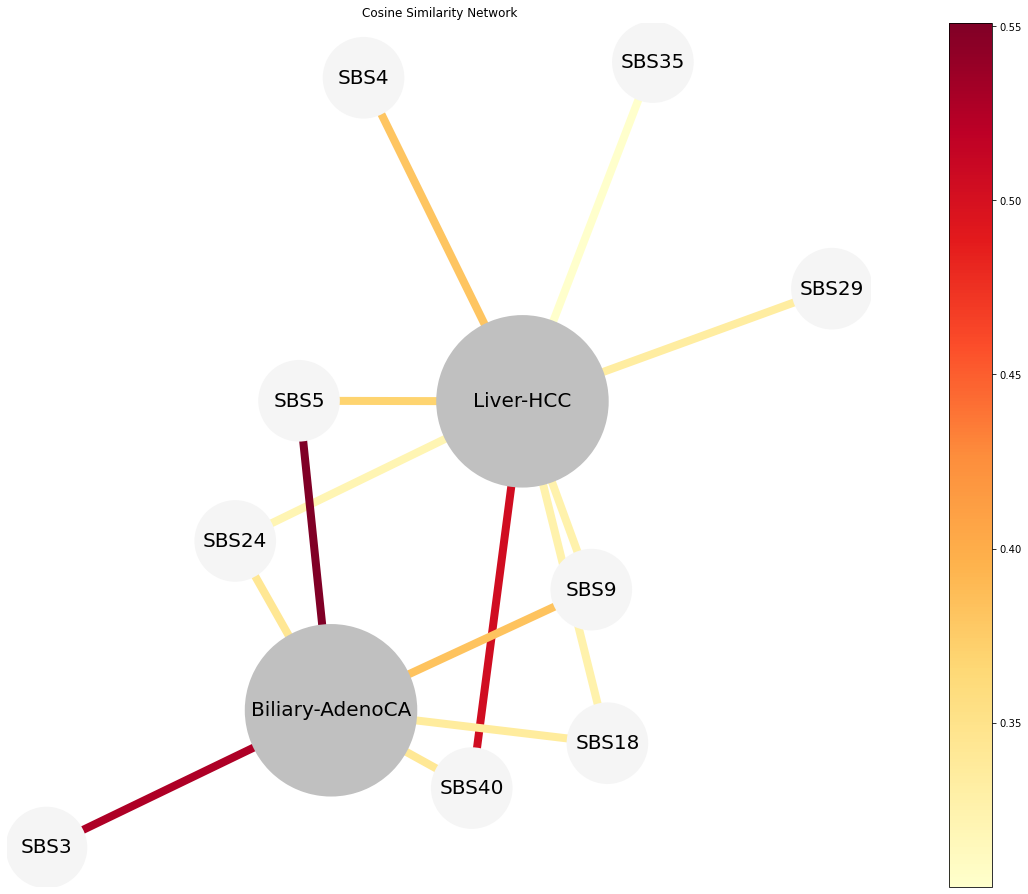

In [48]:
# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered2=combined_df.loc[ (combined_df['value'] > 0.3) & (combined_df['node1'] != combined_df['node2']) ]
links_filtered2
 
plt.figure(2,figsize=(15,12)) 
# Build your graph
G=nx.from_pandas_edgelist(links_filtered2, 'node1', 'node2')
degrees = G.degree()
# Plot the network:
#colors = [i/15 for i in range(15)]
edge_colors = combined_df[combined_df['value']>0.3]['value'].tolist()
node_colors = ["silver" if n in ["Liver-HCC", "Biliary-AdenoCA"] else "whitesmoke" for n in G.nodes()]
node_sizes = [15000 if n in ["Liver-HCC", "Biliary-AdenoCA"] else 1000 for n in G.nodes()]

nx.draw_spring(G, with_labels=True, node_color = node_colors, edge_color=edge_colors, edge_cmap=plt.cm.YlOrRd, node_size=node_sizes,linewidths=50, font_size=20, width=8)

#node_color

#vmin = links_filtered2['value'].min()-(0.1*links_filtered2['value'].mean()) 
#vmin = vmin - (vmin%0.1)
#vmax = links_filtered2['value'].max()+(0.1*links_filtered2['value'].mean()) 
#vmax = vmax + (0.1 - vmax%0.1)

sm = plt.cm.ScalarMappable(cmap="YlOrRd", norm=plt.Normalize(vmin=links_filtered2['value'].min(), vmax=links_filtered2['value'].max()))
sm.set_array([])
cbar = plt.colorbar(sm, anchor=(0.2,0.0))

plt.title("Cosine Similarity Network")
